<a href="https://colab.research.google.com/github/amoutonnet/EyeDisease/blob/master/Analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 align="center">Detecting Eye Diseases Thanks to Machine Learning</h1>

## I. Introduction

Nowadays, data science represents a non-negligible help for physicians for them to be faster and more accurate in their task of detecting diseases. Plus, it is particularly useful in places of the world where there is no trained physicians to assess people. Eye diseases are generally hard to identify before reaching a certain level of development. Diabetic Retinopathy is one of these.  

<img src="https://drive.google.com/uc?id=1Uu7OsMrPGZ1-OLIxXLR754NPz9SMS9a_">

The purpose of this project is to train different learning models to recognize that an eye is ill by analyzing an image of the eye. We have an available database composed of eyes pictures, some of which are ill at different stages. Here is a sample of the database, from stage 0 (not ill) to stage 4 (proliferative diabetic retinopathy):

<img src="https://drive.google.com/uc?id=1RQ-TqUZJo-6lqlO_o_CGGuWdGVv-92OQ">

It seems very hard for an average person to detect the disease by looking at these images, and that is why we are going to implement models to do it for us.

### Prerequisite

To avoid using our own computational power, we will use Google Colab. As we need to deal with files and folders, we will need to virtually mount a drive that will be our Google Drive storage space. It is done thanks to the following code:

In [1]:
from google.colab import drive
drive.mount("/content/drive/")
import os
if not os.path.exists("drive/My Drive/Colab Notebooks/EyeDisease"):
    os.makedirs("drive/My Drive/Colab Notebooks/EyeDisease")
os.chdir("drive/My Drive/Colab Notebooks/EyeDisease")
if not os.path.exists("Datasets"):
    print('You need to put the Images folder and the labels.json file in the Datasets folder before doing anything else.')
    os.makedirs("Datasets")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## II. Obtaining a proper database

We will need the following libraries:

In [2]:
import json  # To deal with json labels file
import numpy as np  # For arrays
from PIL import Image  # To deal with images
from tqdm import tqdm  # For progress bar
from sklearn.model_selection import train_test_split # To split sets
from sklearn.utils import resample  # For upsampling
from sklearn.utils import shuffle  # For shuffling datasets
from sklearn.metrics import classification_report # For accuracy score per class
from sklearn.metrics import accuracy_score # For accuracy score
from collections import Counter # To count labels inside a y array
import h5py # To deal with storage
import matplotlib.pyplot as plt  # To plot things
import warnings
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)
warnings.filterwarnings("ignore")

# Constants
WIDTH=512
HEIGHT=512
IMGSHAPE=(512,512,3)

TensorFlow 2.x selected.
2.0.0


We were given a folder of images with precise names and a json folder contraining a list of tuples with the name of the image file as first element and the label as second element.  
I resized all of the images to have a 512x512 size for every image and dropped four images whose sizes were far less than 512x512 and therefore not usable.  

In [3]:
# Loading the json labels file as a dictionnary
with open('Datasets/labels.json') as f:
    labels = dict(json.load(f))

# Loading the images and creating two arrays X with the images and y with the label
files = os.listdir('Datasets/Images')
y = np.zeros(len(files), dtype='uint8')
X = np.zeros((len(files), HEIGHT, WIDTH, 3), dtype='uint8')
for i, j in tqdm(enumerate(files), total=len(files)):
    im = Image.open('Datasets/Images/'+j)
    im = im.resize((HEIGHT, WIDTH))
    y[i] = labels[j]
    X[i] = im

100%|██████████| 1496/1496 [05:58<00:00,  4.10it/s]


Finally, we need a training set on which we will train the model, a validation set on which we will validate the model during the training and a testing set on which we will test it. The data will be splitted as follow:
* 75% for the training set
* 5% for the validation set
* 20% for the test set  


We take care of keeping the labels proportion in each set with the stratity parameter.

In [0]:
test_size = 20/100
val_size = 5/80


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42, stratify=y_train)

To avoid processing the data everytime, we will save it thanks to the h5 format that allows to deal with heavy data (which is the case of our data as we will store an array of size almost 1500x512x512x3)

In [0]:
file = h5py.File('Datasets/data.h5', 'w')
file.create_dataset(
    "X_train", np.shape(X_train), dtype='uint8', data=X_train, compression="lzf"
)
file.create_dataset(
    "X_test", np.shape(X_test), dtype='uint8', data=X_test, compression="lzf"
)
file.create_dataset(
    "X_val", np.shape(X_val), dtype='uint8', data=X_val, compression="lzf"
)
file.create_dataset(
    "y_train", np.shape(y_train), dtype='uint8', data=y_train, compression="lzf"
)
file.create_dataset(
    "y_test", np.shape(y_test), dtype='uint8', data=y_test, compression="lzf"
)
file.create_dataset(
    "y_val", np.shape(y_val), dtype='uint8', data=y_val, compression="lzf"
)
file.close()

Finally, we will need some functions:
* One to directly load the processed data **If you have already processed and saved**. Note that the images arrays contained images with pixels value from 0 to 255. For technical purpose we will see later, we divide the value by 255 to put it back between 0 and 1.
* One to plot a sample of a dataset
* One to get the composition of a dataset

In [0]:
def load_dataset():
    print('Loading the data...')
    file = h5py.File('Datasets/data.h5', 'r+')
    X_train = np.array(file["/X_train"])/255
    X_test = np.array(file["/X_test"])/255
    X_val = np.array(file["/X_val"])/255
    y_train = np.array(file["/y_train"])
    y_test = np.array(file["/y_test"])
    y_val = np.array(file["/y_val"])
    file.close()
    print('Done.')
    return X_train, X_val, X_test, y_train, y_val, y_test


def plot_sample(X_toplot,y_toplot, title = 'Sample of the database', nb_per_class = 2, transformation=lambda x:x):
    fig, ax = plt.subplots(nrows=nb_per_class, ncols=5, figsize=(20,4*nb_per_class))
    for i in range(5):
        for j in range(nb_per_class):
            try:
                ax[j][i].imshow(np.squeeze(transformation(np.array(X_toplot[np.where(y_toplot == i)[0]][j]))), cmap=plt.get_cmap('gray'))
                if j == 0:
                    ax[j][i].set_title('Stage %d' % (i), fontsize=15)
            except IndexError:
                pass
            ax[j][i].axis('off')
    fig.suptitle(title, fontsize=20)
    plt.show()


def get_composition(ys, names=['training', 'validation', 'testing']):
    fig, ax = plt.subplots(ncols=len(ys), figsize=(6*len(ys),6))
    if not isinstance(ax, np.ndarray):
        ax = [ax]
    for n,y in enumerate(ys):
        elements = Counter(y)
        y_composition = {k : v for k,v in elements.items()}
        y_composition_per = {k : 100*v/sum(elements.values()) for k,v in elements.items()}
        ax[n].bar(y_composition.keys(), y_composition.values())
        for k in y_composition.keys():
            ax[n].annotate('%2.1f%%' % y_composition_per[k], xy=(k+0.4, y_composition[k]+20), color="red", rotation=20, ha="right")
        ax[n].set_ylim([0, max(y_composition.values())+100])
        ax[n].set_title('Composition of the %s set' % names[n])
    plt.setp(ax, xticks=range(len(elements)), xticklabels=['Stage %d' % i for i in range(len(elements))])
    plt.tight_layout()
    plt.show()

## III. The database

We load the dataset that is interesting us:

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = load_dataset()

Loading the data...
Done.


Now we can analyze the composition of the data:

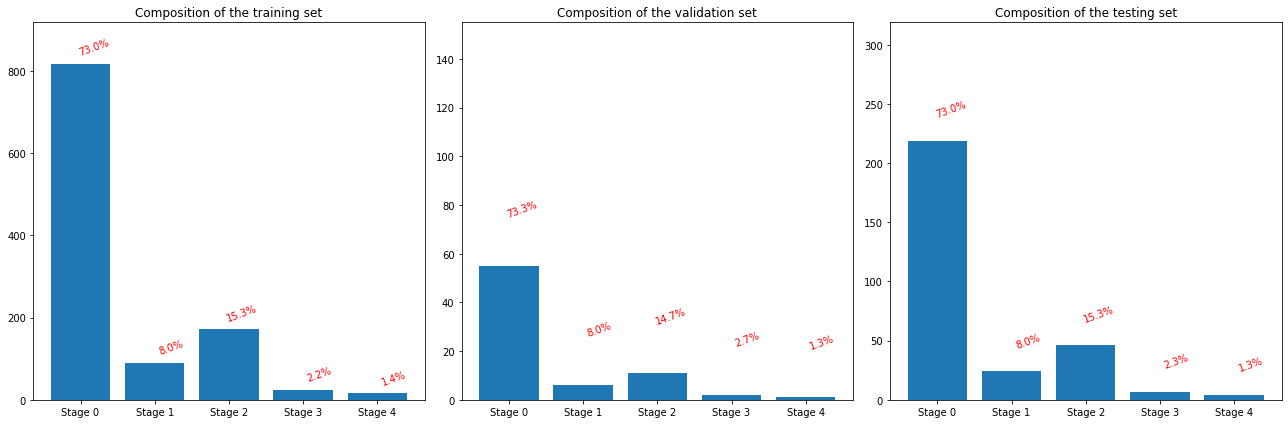

In [8]:
get_composition([y_train, y_val, y_test])

The proportions are the same, but this data set is clearly unbalanced. We will need to deal with this issue in the future.  
The following lines of code will show a sample of the database, allowing us to analyze it.

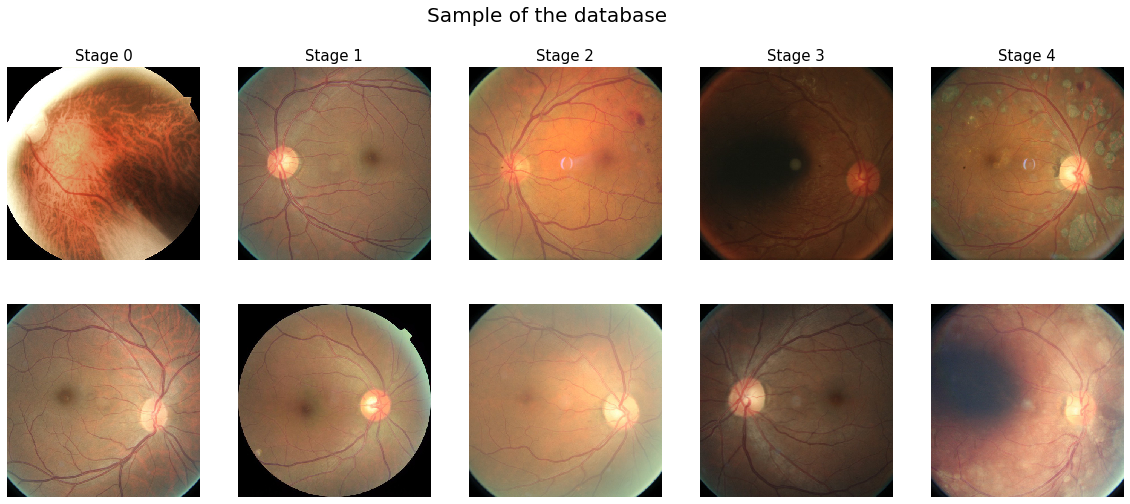

In [11]:
plot_sample(X_test, y_test)

The images are very different in their zoom and even rotation (maybe they are even flipped). There are some stains/shadows on images. In front of such disorder we will apply data augmentation techniques in order to have a more robust model and prevent overfitting. The following lines of code will create a generator that will modify images fed to the model during the training. Modifications include zooms, rotations and flips.


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1, # Randomly zoom image in the range 0% to 10%
        fill_mode='constant', # we fill the rest of the modified image with the same value
        cval=0, # which is 0, meaning it will be black
        shear_range=10,
        horizontal_flip=True, # randomly flip images horizontally
        vertical_flip=True, # randomly flip images vertically
        dtype=np.float32) # use float32 for memory purposes

Here is a sample of the database with augmentation techniques applied on it:

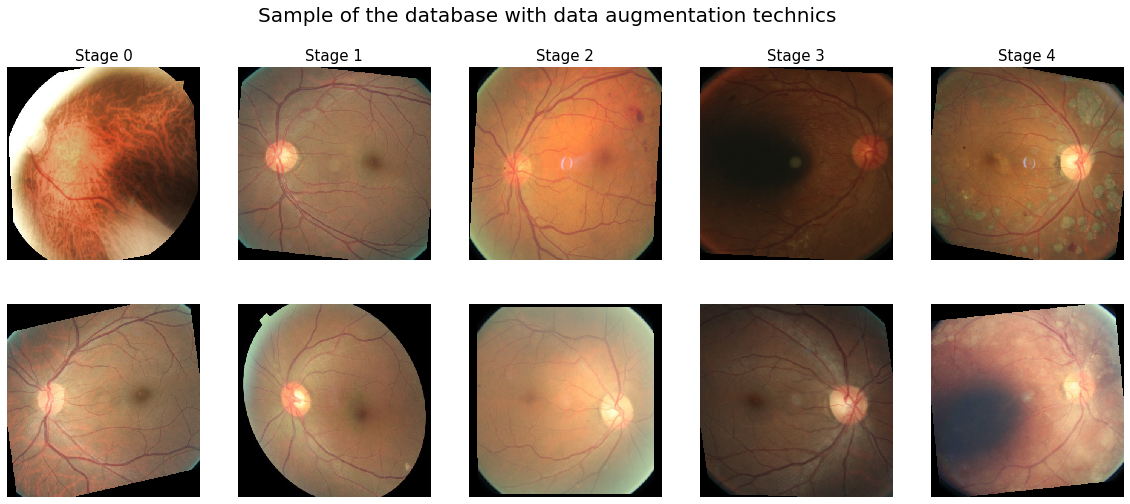

In [13]:
plot_sample(X_test, y_test, title = 'Sample of the database with data augmentation technics', transformation=lambda x : datagen.apply_transform(x, datagen.get_random_transform(IMGSHAPE)))

## IV. The first model : A classical CNN from scratch

### The dataset

We load the dataset


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = load_dataset()

Loading the data...
Done.


As the dataset is unbalanced, we need to upsample the minority classes and, as the memory is precious here, downsample the majority class



In [0]:
target_size = 100
for k, v in Counter(y_train).items():
    obj = target_size - v
    if obj > 0:
        X_train = np.concatenate([X_train, resample(X_train[np.where(y_train==k)[0]], replace=True, n_samples = obj, random_state=42)])
        y_train = np.concatenate([y_train, k*np.ones((obj,))])
    elif obj < 0:
        mask = np.ones((len(y_train),), dtype=bool)
        mask[np.where(y_train==k)[0][obj:]] = False
        X_train = X_train[mask]
        y_train = y_train[mask]
    else:
        pass

We can verify that the training set is now well balanced:

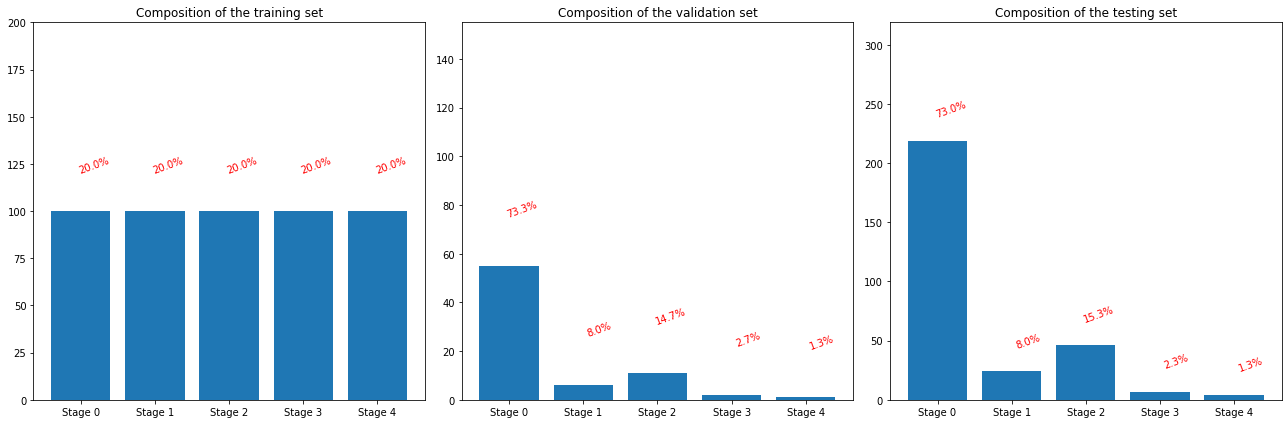

In [7]:
get_composition([y_train, y_val, y_test])

### The model

Now we are ready to tackle our model. We will use a convolutionnal neural network that will take as input the an image of size 512x512 with 3 channels.
We will use 5 blocks and one block of this convolutionnal network will be a succession of:


1.   a convolution layer with a 3x3 filter
2.   a convolution layer with a 4x4 filter
3.   a average pooling layer with a pool size of 2x2 
4.   a batchnormalization layer (to avoid overfitting)


We will double the number of filter after each block, starting with 32 filters on the first one. At the end we will of course flatten the whole thing and finish with a dense layer with a softmax activation in order to obtain a "probability" for the eye to be ill at a certain stage.

In [8]:
# We need to initialize weights far from zero to avoid a convergence to the same prediction everytime
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=15)

first_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMGSHAPE, kernel_initializer=initializer),
        tf.keras.layers.Conv2D(32, (4,4), activation='relu', kernel_initializer=initializer),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer=initializer),
        tf.keras.layers.Conv2D(64, (4,4), activation='relu', kernel_initializer=initializer),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer=initializer),
        tf.keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=initializer),
        tf.keras.layers.AveragePooling2D((2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation='softmax', kernel_initializer=initializer, bias_initializer=initializer)
])
first_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 507, 507, 32)      16416     
_________________________________________________________________
average_pooling2d (AveragePo (None, 253, 253, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 253, 253, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 251, 251, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 248, 248, 64)      65600     
_________________________________________________________________
average_pooling2d_1 (Average (None, 124, 124, 64)      0

### The training
We will train the model on the generated images from the data augmentation generators.  



In [0]:
# Load the saved model if reset is False
reset = True
if not reset:
    first_model.load_weights('Models/first_mod_best.h5')

# Compile the model
first_model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Setting checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint('Models/first_mod_best.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

# Setting learning rate adaptation when the training is stuck on a plateau
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=3, min_lr=0.00005)

# Setting early stopping if val_loss does not change anymore
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

callbacks_list = [checkpoint, reduceLROnPlat, earlystop]

# Data augmentation generator
batch_size = 32
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, seed=32) # Will generate batched of random processed image during training

In [10]:
# first_history = first_model.fit_generator(train_gen, epochs=100, steps_per_epoch = X_train.shape[0] // batch_size, validation_data=(X_val, y_val), callbacks = callbacks_list,)
first_history = first_model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks = callbacks_list,)
first_model.save_weights('Models/first_model_last.h5')

Train on 500 samples, validate on 75 samples
Epoch 1/100
480/500 [===========================>..] - ETA: 0s - loss: 48.4170 - accuracy: 0.3187
Epoch 00001: val_loss improved from inf to 26.31131, saving model to Models/first_mod_best.h5
500/500 [==============================] - 18s 36ms/sample - loss: 48.3157 - accuracy: 0.3120 - val_loss: 26.3113 - val_accuracy: 0.1067
Epoch 2/100
480/500 [===========================>..] - ETA: 0s - loss: 23.5552 - accuracy: 0.4979
Epoch 00002: val_loss improved from 26.31131 to 14.91403, saving model to Models/first_mod_best.h5
500/500 [==============================] - 8s 15ms/sample - loss: 23.3865 - accuracy: 0.4940 - val_loss: 14.9140 - val_accuracy: 0.2400
Epoch 3/100
480/500 [===========================>..] - ETA: 0s - loss: 16.2072 - accuracy: 0.6021
Epoch 00003: val_loss did not improve from 14.91403
500/500 [==============================] - 7s 15ms/sample - loss: 16.5044 - accuracy: 0.5980 - val_loss: 16.9901 - val_accuracy: 0.2133
Epoch 4

Let's analyze the training phase:

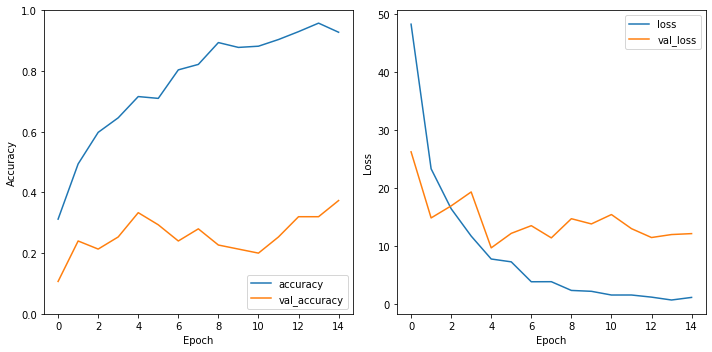

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(first_history.history['accuracy'], label='accuracy')
ax[0].plot(first_history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0, 1])
ax[0].legend(loc='lower right')
ax[1].plot(first_history.history['loss'], label='loss')
ax[1].plot(first_history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

On this plot we can clearly see that there is no overfitting (both line are increasing at the same pace). However, the training rapidly reaches a plateau stopping the progression. Our model is not good enough to perform better than a 73% accuracy on this dataset.

### The testing

We want to see the accuracy per class, because the dataset is really unbalanced and we need to know if it is a problem.

In [13]:
first_model.load_weights('Models/first_mod_best.h5')
y_pred = first_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy on the test set : %.1f%%" % (100*accuracy_score(y_test, y_pred)))
print("Accuracy per stage : \n", classification_report(y_test, y_pred))

Accuracy on the test set : 30.3%
Accuracy per stage : 
               precision    recall  f1-score   support

           0       0.78      0.33      0.46       219
           1       0.07      0.33      0.11        24
           2       0.14      0.24      0.17        46
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4

    accuracy                           0.30       300
   macro avg       0.20      0.18      0.15       300
weighted avg       0.60      0.30      0.37       300



## V. The second model : using transfert learning with EfficientNet

We saw that event if our CNN has not so many parameters, it is hard for a model to start from scratch with the training for such a tough mission that is detecting the illness by analyzing the image.  
Hence, our next step is to use transfert learning with a neural network that has proven its efficiency : EfficientNet from Google:



In [26]:
# We reload the dataset
X_train, X_val, X_test, y_train, y_val, y_test = load_dataset()

# We balance the dataset
target_size = 100
for k, v in Counter(y_train).items():
    obj = target_size - v
    if obj > 0:
        X_train = np.concatenate([X_train, resample(X_train[np.where(y_train==k)[0]], replace=True, n_samples = obj, random_state=42)])
        y_train = np.concatenate([y_train, k*np.ones((obj,))])
    elif obj < 0:
        mask = np.ones((len(y_train),), dtype=bool)
        mask[np.where(y_train==k)[0][obj:]] = False
        X_train = X_train[mask]
        y_train = y_train[mask]
    else:
        pass
    
# We install efficientnet
!pip install git+https://github.com/qubvel/efficientnet

# We import it
from efficientnet.tfkeras import EfficientNetB3

Loading the data...
Done.
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-v8juk0k5
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-v8juk0k5
  Created wheel for efficientnet: filename=efficientnet-1.0.0-cp36-none-any.whl size=17686 sha256=c4ac17b4f925245ebf8a324d1347e84390e064661881490d55b005b0c8bab1bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-d7_j22z7/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


We build the model:

In [32]:
# We create the base of the model that will be the pretrained one
eff_net = EfficientNetB3(weights='imagenet', include_top=False, input_shape=IMGSHAPE)

# This base must be not trainable
eff_net.trainable = False

# We add some Dense layer to it, with a dropout to avoid overfitting
x = eff_net.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
preds = tf.keras.layers.Dense(5, activation="softmax")(x)
second_model = tf.keras.Model(inputs = eff_net.input, outputs = preds)
second_model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
second_model.summary()

# Load a saved model
reset = True

if not reset:
    second_model.load_weights('Models/second_mod_best.h5')
    print('Model loaded!')

# We define callbacks

# Setting checkpoints
checkpoint = tf.keras.callbacks.ModelCheckpoint('Models/second_mod_best.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

# Setting learning rate adaptation when the training is stuck on a plateau
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.00005, cooldown=3, min_lr=0.00001)

# Setting early stopping if val_loss does not change anymore
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

callbacks_list = [checkpoint, reduceLROnPlat, earlystop]

# Data augmentation generator
batch_size = 8
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size, seed=32) # Will generate batched of random processed image during training

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 40) 1080        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

Now we can train the model:

In [34]:
# second_history = second_model.fit_generator(train_gen, epochs=100, steps_per_epoch = X_train.shape[0] // batch_size, validation_data=(X_val, y_val), callbacks = callbacks_list,)
second_history = second_model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks = callbacks_list,)
second_model.save_weights('Models/second_model_last.h5')

Train on 500 samples, validate on 75 samples
Epoch 1/100
496/500 [============================>.] - ETA: 0s - loss: 1.5464 - accuracy: 0.2661
Epoch 00001: val_loss did not improve from 1.52091
500/500 [==============================] - 18s 35ms/sample - loss: 1.5469 - accuracy: 0.2640 - val_loss: 1.6699 - val_accuracy: 0.6667
Epoch 2/100
496/500 [============================>.] - ETA: 0s - loss: 1.5134 - accuracy: 0.3065
Epoch 00002: val_loss did not improve from 1.52091
500/500 [==============================] - 8s 16ms/sample - loss: 1.5142 - accuracy: 0.3060 - val_loss: 1.7693 - val_accuracy: 0.6267
Epoch 3/100
496/500 [============================>.] - ETA: 0s - loss: 1.4841 - accuracy: 0.3065
Epoch 00003: val_loss did not improve from 1.52091
500/500 [==============================] - 9s 17ms/sample - loss: 1.4831 - accuracy: 0.3080 - val_loss: 1.6105 - val_accuracy: 0.5467
Epoch 4/100
496/500 [============================>.] - ETA: 0s - loss: 1.4829 - accuracy: 0.2823
Epoch 00004

Let's analyze the training phase

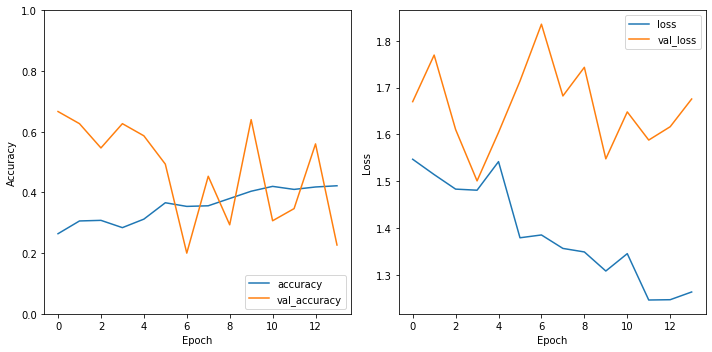

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(second_history.history['accuracy'], label='accuracy')
ax[0].plot(second_history.history['val_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0, 1])
ax[0].legend(loc='lower right')
ax[1].plot(second_history.history['loss'], label='loss')
ax[1].plot(second_history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()

### Testing

Now we can test the performance of our trained model on the dataset:

In [37]:
second_model.load_weights('Models/second_mod_best.h5')
y_pred = second_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy on the test set : %.1f%%" % (100*accuracy_score(y_test, y_pred)))
print("Accuracy per stage : \n", classification_report(y_test, y_pred))

Accuracy on the test set : 53.3%
Accuracy per stage : 
               precision    recall  f1-score   support

           0       0.74      0.69      0.71       219
           1       0.00      0.00      0.00        24
           2       0.15      0.20      0.17        46
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         4

    accuracy                           0.53       300
   macro avg       0.18      0.18      0.18       300
weighted avg       0.56      0.53      0.55       300



## VI. Comparison of the two models and conclusion

The results on the test set are far better with the pretrained model from Google (53.3% compare to 30.3%). In fact, training a model from scratch with such a complicate data seems absurd when you only have one GPU available. Therefore, using a pretrained model that is already able to deal very well with images is mandatory.  
We can see that there is clearly some overfitting in both models. It could have been better by using the data augmentation techniques described at the end of III. However, their utilisation must come with a longer training and models with more parameters to be useful, and of course occur computational costs which we cannot afford.